In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

In [16]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['x0','y0','dummy'])
df.head()

,x0,y0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


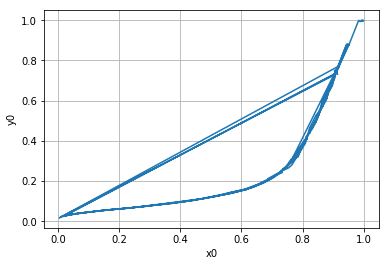

In [17]:
x0 = df.x0.values
y0 = df.y0.values
x = x0/np.max(x0)
y = y0/np.max(y0)
plt.plot(x,y)
plt.xlabel('x0')
plt.ylabel('y0')
plt.grid()

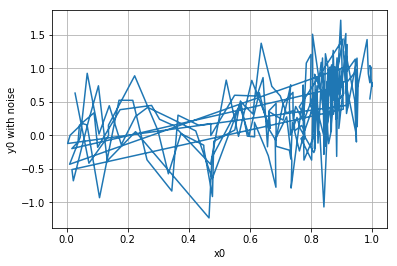

In [18]:
noise = np.random.normal(0.0,0.5,y.size)
yn = y+noise
plt.plot(x,yn)
plt.xlabel('x0')
plt.ylabel('y0 with noise')
plt.grid()


In [19]:
from sklearn.model_selection import train_test_split

xtr,xts,ytr,yts = train_test_split(x,yn,test_size = 0.33)

In [20]:
def predict(x,w):
    d = (len(w)-1)//2
    a = w[:d+1]
    b = w[d+1:]
    reva = np.flip(a)
    revb = np.flip(b)
    
    yhat = np.polyval(a,x)/(1+np.polyval(b,x))
    return yhat

In [21]:
d = 3
transformedX = np.zeros([len(x),d])
transformedY = np.zeros([len(y),d])
z = np.zeros([len(x),2*d])
for j,val in enumerate(x):
    for i in range(d):
        tranX = x[j]**i
        tranY = tranX * y[j]
        transformedX[j,i] = tranX
        transformedY[j,i] = tranY
    z[j] = np.append(transformedX[j],transformedY[j])
regr = LinearRegression()
regr.fit(z,yn)
coeffs = regr.coef_
intercept = regr.intercept_
winit = np.append(intercept,coeffs)

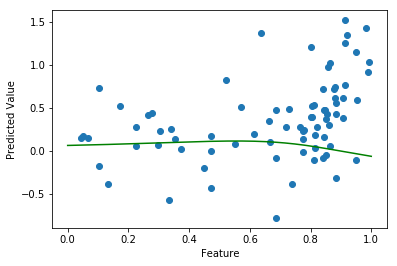

In [22]:
xp = np.linspace(0,1,1000)
yhat = predict(xp,winit)
plt.plot(xp,yhat,"g-")
plt.scatter(xts,yts)
plt.xlabel("Feature")
plt.ylabel("Predicted Value")
plt.show()

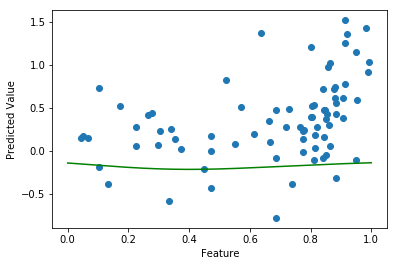

In [23]:
regr = Ridge(alpha=1e-3)
regr.fit(z,yn)

coeffs = regr.coef_
intercept = regr.intercept_
winit = np.append(intercept,coeffs)

xp = np.linspace(0,1,1000)
yhat = predict(xp,winit)
plt.plot(xp,yhat,"g-")
plt.scatter(xts,yts)
plt.xlabel("Feature")
plt.ylabel("Predicted Value")
plt.show()

In [24]:
def feval(w,x,y):    
    d = (len(w)-1)//2
    a = w[:d+1]
    b = w[d+1:]
    
    Znum = np.zeros([len(x),d+1])
    Zden = np.zeros([len(x),d])
    
    for i in range(len(x)):
        for j in range(d):
            Znum[i,j] = x[i]**j
            Zden[i,j] = x[i]**(j+1)
    
    
    # TODO.  Compute yhat 
    # Compute the numerator and denominator
    numerator = a.dot(Znum.T)
    denominator = (1+b.dot(Zden.T))
    yhat = numerator/denominator

    # TODO.  Compute loss
    # f = ...
    f = 0.5*np.sum((y-yhat)**2)
    
    # TODO.  Compute gradients
    # fgrad = ...
    first = (y-yhat)
    df_da = -(first[None,:].dot((Znum.T/denominator).T))
    
    df_db = ((first[None,:].dot(((numerator*Zden.T)/denominator**2).T)))
    fgrad = np.append(df_da,df_db)
    
    return f, fgrad

In [25]:
w0=winit 

step = 1e-6
p = len(w0)

w1 = w0 + step*np.random.randn(p)
f0,fgrad0 = feval(w0,xtr,ytr)
f1,fgrad1 = feval(w1,xtr,ytr)

df_est = fgrad0.dot(w1-w0)
    
print("Actual f1-f0    = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)


Actual f1-f0    =   2.5478e-05
Predicted f1-f0 =   2.5478e-05


Text(0, 0.5, 'Objective loss function')

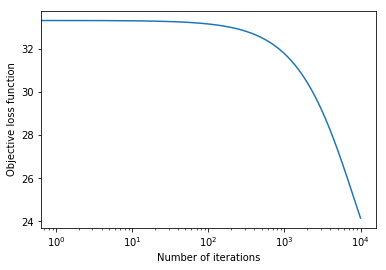

In [26]:
w0 = winit
nit = 10000
lr = 1e-6

fgd = np.zeros(nit)
for it in range(nit):
    f0, fgrad0 = feval(w0,xtr,ytr)
    w0 = w0 - lr*fgrad0
    fgd[it] = f0
t = np.arange(nit)
plt.semilogx(t,fgd)
plt.xlabel("Number of iterations")
plt.ylabel("Objective loss function")

Text(0, 0.5, 'Objective loss function')

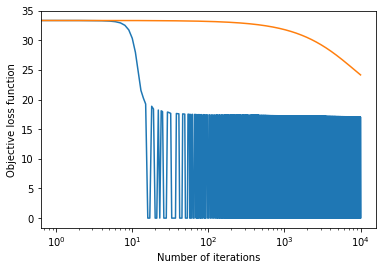

In [27]:
nit = 10000
w0 = winit
f0, fgrad0 = feval(w0, xtr,ytr)
lr = 1e-6
fadapt = np.zeros(nit)
for it in range(nit):
    w1 = w0 - lr*fgrad0

    f1, fgrad1 = feval(w1,xtr,ytr)
    df_est = fgrad0.dot(w1-w0)
        
    alpha = 0.5
    if (f1-f0 < alpha*df_est) and (f1 < f0):
        lr = lr*2
        f0 = f1
        fgrad0 = fgrad1
        fadapt[it] = f1
        w0 = w1
    else:
        lr = lr/2
    
t = np.arange(nit)
plt.semilogx(t,fadapt,label="Using Adaptive step gradient Descent")
plt.semilogx(t,fgd, label="Using simple gradient descent")
plt.xlabel("Number of iterations")
plt.ylabel("Objective loss function")

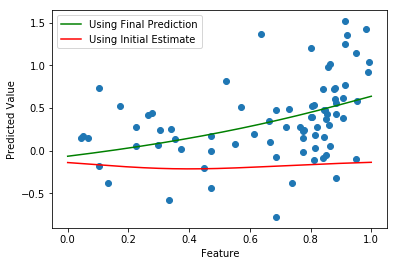

In [28]:
xp = np.linspace(0,1,1000)
yhat = predict(xp,w0)
plt.plot(xp,yhat,"g-",label="Using Final Prediction")
yhatpred = predict(xp,winit)
plt.plot(xp,yhatpred,"r-",label = "Using Initial Estimate")
plt.scatter(xts,yts)
plt.xlabel("Feature")
plt.ylabel("Predicted Value")
plt.legend()
plt.show()